In [47]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler

# for confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

#### 1. Data import

In [48]:
# group 1 datas
sensor1 = pd.read_csv('raw_data/g1_sensor1.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor2 = pd.read_csv('raw_data/g1_sensor2.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor3 = pd.read_csv('raw_data/g1_sensor3.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor4 = pd.read_csv('raw_data/g1_sensor4.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])

sensor1

,time,normal,type1,type2,type3
0,0.000000,-0.853307,-3.464579,0.555219,3.919664
1,0.000736,-0.740463,-2.448986,-0.234687,4.145351
2,0.001472,-0.138630,-1.922383,-0.009000,2.941685
3,0.002208,0.049443,-0.906790,-0.272301,2.603155
4,0.002944,-0.289088,-0.568259,-0.986978,1.361874
...,...,...,...,...,...
190213,139.996768,-1.156354,-2.696750,0.844491,-2.109427
190214,139.997504,-0.930666,-1.380241,0.919720,-2.222270
190215,139.998240,-0.554521,-2.132532,0.731647,-2.109427
190216,139.998976,-1.419655,-2.433448,1.183022,-3.087405


In [49]:
print('sensor 1의 데이터 크기', sensor1.shape)
print('sensor 2의 데이터 크기', sensor2.shape)
print('sensor 3의 데이터 크기', sensor3.shape)
print('sensor 4의 데이터 크기', sensor4.shape)

sensor 1의 데이터 크기 (190218, 5)
sensor 2의 데이터 크기 (184211, 5)
sensor 3의 데이터 크기 (196079, 5)
sensor 4의 데이터 크기 (183969, 5)


#### 2. Data preprocessing

##### 2.1. Data interpolation
- To resample data of different sizes due to different sampling times.

In [50]:
x_new  = np.arange(0, 140, 0.001)
y_new1, y_new2, y_new3, y_new4 = [], [], [], []

for item in ['normal', 'type1', 'type2', 'type3']:
    
    f_linear1 = interpolate.interp1d(sensor1['time'], sensor1[item], kind='linear')
    y_new1.append(f_linear1(x_new))
    f_linear2 = interpolate.interp1d(sensor2['time'], sensor2[item], kind='linear')
    y_new2.append(f_linear2(x_new))
    f_linear3 = interpolate.interp1d(sensor3['time'], sensor3[item], kind='linear')
    y_new3.append(f_linear3(x_new))
    f_linear4 = interpolate.interp1d(sensor4['time'], sensor4[item], kind='linear')
    y_new4.append(f_linear4(x_new))
 
sensor1 = pd.DataFrame(np.array(y_new1).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor2 = pd.DataFrame(np.array(y_new2).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor3 = pd.DataFrame(np.array(y_new3).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor4 = pd.DataFrame(np.array(y_new4).T, columns = ['normal', 'type1', 'type2', 'type3'])

print('resampled sensor 1 data shape', sensor1.shape)
print('resampled sensor 2 data shape', sensor2.shape)
print('resampled sensor 3 data shape', sensor3.shape)
print('resampled sensor 4 data shape', sensor4.shape)

resampled sensor 1 data shape (140000, 4)
resampled sensor 2 data shape (140000, 4)
resampled sensor 3 data shape (140000, 4)
resampled sensor 4 data shape (140000, 4)


In [51]:
# concatenation with same types
normal_ = pd.concat([sensor1['normal'], sensor2['normal'], sensor3['normal'], sensor4['normal']], axis=1)
type1_  = pd.concat([sensor1['type1'], sensor2['type1'], sensor3['type1'], sensor4['type1']], axis=1)
type2_  = pd.concat([sensor1['type2'], sensor2['type2'], sensor3['type2'], sensor4['type2']], axis=1)
type3_  = pd.concat([sensor1['type3'], sensor2['type3'], sensor3['type3'], sensor4['type3']], axis=1)

normal_.columns = ['s1', 's2', 's3', 's4'];  type1_.columns = ['s1', 's2', 's3', 's4']
type2_.columns = ['s1', 's2', 's3', 's4'];   type3_.columns = ['s1', 's2', 's3', 's4']

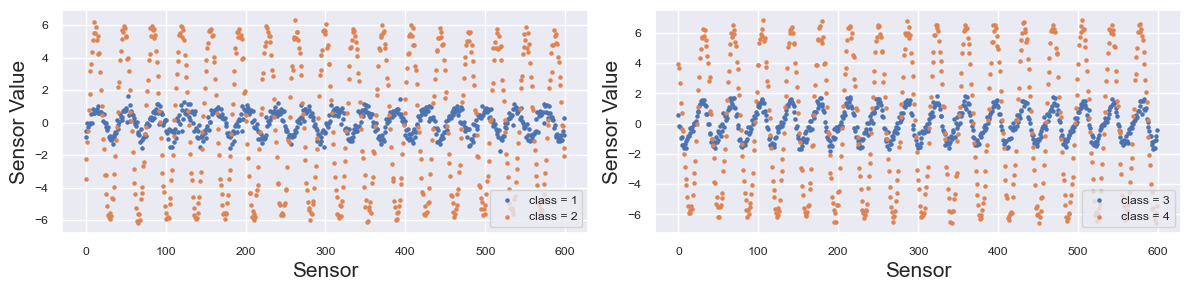

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].scatter(range(0, 600), normal_['s1'][:600], label="class = 1", marker='o', s=5)
axes[0].scatter(range(0, 600), type1_['s1'][:600], label="class = 2", marker='o', s=5)
axes[0].legend(loc="lower right")
axes[0].set_xlabel("Sensor", fontsize=15)
axes[0].set_ylabel("Sensor Value", fontsize=15)

axes[1].scatter(range(0, 600), type2_['s1'][:600], label="class = 3", marker='o', s=5)
axes[1].scatter(range(0, 600), type3_['s1'][:600], label="class = 4", marker='o', s=5)
axes[1].legend(loc="lower right")
axes[1].set_xlabel("Sensor", fontsize=15)
axes[1].set_ylabel("Sensor Value", fontsize=15)

plt.tight_layout()

plt.show()

<Axes: >

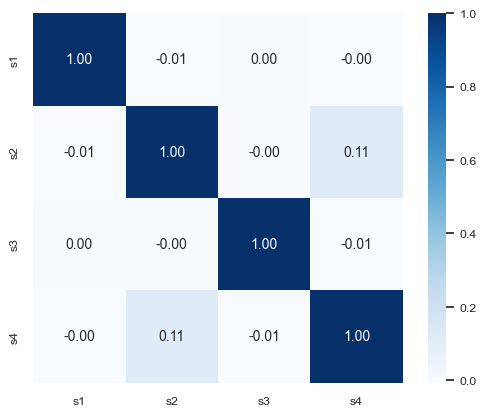

In [53]:
# data correlation
names = ['s1','s2','s3','s4']
cm = np.corrcoef(normal_[names].values.T)
sns.set(font_scale=0.8)
sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
yticklabels=names, xticklabels=names, cmap=plt.cm.Blues)

##### 2.2. Moving Average Filter
- To reduce the effect of noise

In [54]:
M = 15

# meaning of valid : 두 배열이 완전히 겹칠때만 수행
normal_s1 = np.convolve(normal_['s1'], np.ones(M), 'valid') / M;    normal_s1 = normal_s1.reshape(len(normal_s1),1)
normal_s2 = np.convolve(normal_['s2'], np.ones(M), 'valid') / M;    normal_s2 = normal_s2.reshape(len(normal_s2),1)
normal_s3 = np.convolve(normal_['s3'], np.ones(M), 'valid') / M;    normal_s3 = normal_s3.reshape(len(normal_s3),1)
normal_s4 = np.convolve(normal_['s4'], np.ones(M), 'valid') / M;    normal_s4 = normal_s4.reshape(len(normal_s4),1)

type1_s1 = np.convolve(type1_['s1'], np.ones(M), 'valid') / M;  type1_s1 = type1_s1.reshape(len(type1_s1),1)
type1_s2 = np.convolve(type1_['s2'], np.ones(M), 'valid') / M;  type1_s2 = type1_s2.reshape(len(type1_s2),1)
type1_s3 = np.convolve(type1_['s3'], np.ones(M), 'valid') / M;  type1_s3 = type1_s3.reshape(len(type1_s3),1)
type1_s4 = np.convolve(type1_['s4'], np.ones(M), 'valid') / M;  type1_s4 = type1_s4.reshape(len(type1_s4),1)

type2_s1 = np.convolve(type2_['s1'], np.ones(M), 'valid') / M;  type2_s1 = type2_s1.reshape(len(type2_s1),1)
type2_s2 = np.convolve(type2_['s2'], np.ones(M), 'valid') / M;  type2_s2 = type2_s2.reshape(len(type2_s2),1)
type2_s3 = np.convolve(type2_['s3'], np.ones(M), 'valid') / M;  type2_s3 = type2_s3.reshape(len(type2_s3),1)
type2_s4 = np.convolve(type2_['s4'], np.ones(M), 'valid') / M;  type2_s4 = type2_s4.reshape(len(type2_s4),1)

type3_s1 = np.convolve(type3_['s1'], np.ones(M), 'valid') / M;  type3_s1 = type3_s1.reshape(len(type3_s1),1)
type3_s2 = np.convolve(type3_['s2'], np.ones(M), 'valid') / M;  type3_s2 = type3_s2.reshape(len(type3_s2),1)
type3_s3 = np.convolve(type3_['s3'], np.ones(M), 'valid') / M;  type3_s3 = type3_s3.reshape(len(type3_s3),1)
type3_s4 = np.convolve(type3_['s4'], np.ones(M), 'valid') / M;  type3_s4 = type3_s4.reshape(len(type3_s4),1)

# 같은 class들끼리 arrange
normal_temp = np.concatenate((normal_s1, normal_s2, normal_s3, normal_s4), axis =1)
type1_temp  = np.concatenate((type1_s1, type1_s2, type1_s3, type1_s4), axis =1)
type2_temp  = np.concatenate((type2_s1, type2_s2, type2_s3, type2_s4), axis =1)
type3_temp  = np.concatenate((type3_s1, type3_s2, type3_s3, type3_s4), axis =1)

#### 2.3. Min-Max scaler

In [55]:
scaler = MinMaxScaler()
scaler.fit(normal_)
normal = scaler.transform(normal_temp)
type1  = scaler.transform(type1_temp)
type2  = scaler.transform(type2_temp)
type3  = scaler.transform(type3_temp)

c:\Users\hanmu\anaconda3\envs\py39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\hanmu\anaconda3\envs\py39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\hanmu\anaconda3\envs\py39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\hanmu\anaconda3\envs\py39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


#### 2.4. Pre-processed data

In [56]:
print(normal)
print('------------------------------------------------')
print('normal data size = ', normal.shape)

[[0.57598822 0.50553898 0.56439491 0.44551164]
 [0.60960317 0.50513674 0.58169332 0.44848001]
 [0.62990663 0.5047345  0.59547186 0.46260474]
 ...
 [0.51874981 0.50106998 0.60999194 0.50715712]
 [0.49713039 0.51588928 0.6074125  0.53093987]
 [0.45708747 0.52025039 0.60349765 0.53976513]]
------------------------------------------------
normal data size =  (139986, 4)


In [57]:
# steady - state data acquisition
normal = normal[30000:130000][:]
type1  = type1[30000:130000][:]
type2  = type2[30000:130000][:]
type3  = type3[30000:130000][:]

In [58]:
# data split
# proportion : [train : validation : test] = 6 : 2 : 2
normal_train  =  normal[:][:60000];   normal_valid = normal[:][60000:80000]; normal_test = normal[:][80000:]
type1_train   =  type1[:][:60000];    type1_valid = type1[:][60000:80000];   type1_test  = type1[:][80000:]
type2_train   =  type2[:][:60000];    type2_valid = type2[:][60000:80000];   type2_test  = type2[:][80000:]
type3_train   =  type3[:][:60000];    type3_valid = type3[:][60000:80000];   type3_test  = type3[:][80000:]
train         =  np.concatenate((normal_train, type1_train, type2_train, type3_train))
valid         =  np.concatenate((normal_valid, type1_valid, type2_valid, type3_valid))
test          =  np.concatenate((normal_test, type1_test, type2_test, type3_test))

print("train data의 형태:", train.shape)
print("valid data의 형태:", valid.shape)
print(" test data의 형태:", test.shape)

train data의 형태: (240000, 4)
valid data의 형태: (80000, 4)
 test data의 형태: (80000, 4)


#### 2.5. Data labeling

In [59]:
train_label = np.concatenate((np.full((60000,1),0), np.full((60000,1),1), np.full((60000,1),2), np.full((60000,1),3)))
valid_label = np.concatenate((np.full((20000,1),0), np.full((20000,1),1), np.full((20000,1),2), np.full((20000,1),3)))
test_label  = np.concatenate((np.full((20000,1),0), np.full((20000,1),1), np.full((20000,1),2), np.full((20000,1),3)))

In [60]:
# data shuffle
idx = np.arange(train.shape[0]); np.random.shuffle(idx)
train = train[:][idx]; train_label = train_label[:][idx]

idx_v = np.arange(valid.shape[0]); np.random.shuffle(idx_v)
valid = valid[:][idx_v]; valid_label = valid_label[:][idx_v]

idx_t = np.arange(test.shape[0]); np.random.shuffle(idx_t)
test = test[:][idx_t]; test_label = test_label[:][idx_t]

### 3. Model training
- Pytorch 머신러닝 모듈 : tensor 형태의 데이터를 입력으로 받기 때문에, 데이터의 형태를 array에서 tensor로 변환

In [61]:
x_train = torch.from_numpy(train).float()
y_train = torch.from_numpy(train_label).float().T[0]
x_valid = torch.from_numpy(valid).float()
y_valid = torch.from_numpy(valid_label).float().T[0]
x_test = torch.from_numpy(test).float()
y_test = torch.from_numpy(test_label).float().T[0]

In [62]:
train = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train, batch_size =5000, shuffle=True)
valid = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid, batch_size =len(x_valid), shuffle=False)
test = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test, batch_size =len(x_valid), shuffle=False)

#### 3.1. DNN model

In [63]:
class KAMP_DNN(nn.Module):
    
    def __init__(self):
        
        super(KAMP_DNN, self).__init__()
        self.layer1 = nn.Linear(in_features =4, out_features =100)
        self.layer2 = nn.Linear(in_features =100, out_features =100)
        self.layer3 = nn.Linear(in_features =100, out_features =100)
        self.layer4 = nn.Linear(in_features =100, out_features =4)
 
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
    def forward(self, input):
        
        out =self.layer1(input)
        out =self.relu(out)
        out =self.dropout(out)
        
        out =self.layer2(out)
        out =self.relu(out)
        out =self.dropout(out)
        
        out =self.layer3(out)
        out =self.relu(out)
        out =self.dropout(out)
        
        out =self.layer4(out)
        
        return out
 
model_check = KAMP_DNN()
print(model_check)

KAMP_DNN(
  (layer1): Linear(in_features=4, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


#### 3.2. CNN model

In [64]:
class KAMP_CNN(nn.Module):
    
    def __init__(self):
        
        super(KAMP_CNN, self).__init__()
        self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=100, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1),
        nn.Dropout(p=0.2))
 
        # self.conv2 = nn.Sequential(
        # nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, stride=1, padding='same'),
        # nn.BatchNorm1d(100),
        # nn.ReLU(),
        # nn.MaxPool1d(kernel_size=1, stride=1),
        # nn.Dropout(p=0.2))
        
        # self.conv3 = nn.Sequential(
        # nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, stride=1, padding='same'),
        # nn.BatchNorm1d(100),
        # nn.ReLU(),
        # nn.MaxPool1d(kernel_size=1, stride=1),
        # nn.Dropout(p=0.2))
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=4, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(4),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1))
        
        self.final_pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(4, 4)
        
    def forward(self, input):
        
        input = input.unsqueeze(1)
        out =self.conv1(input)
        # out = self.conv2(out)
        # out = self.conv3(out)
        out =self.conv4(out)
        out =self.final_pool(out)
        out =self.linear(out.squeeze(-1))
        
        return out  
                                                       
model_check = KAMP_CNN()
print(model_check)

KAMP_CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 100, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv1d(100, 4, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (final_pool): AdaptiveAvgPool1d(output_size=1)
  (linear): Linear(in_features=4, out_features=4, bias=True)
)


#### 3.3. RNN model

In [65]:
class KAMP_RNN(nn.Module):
    
    def __init__(self):
        
        super(KAMP_RNN, self).__init__()
        self.lstm = nn.LSTM(input_size =4, hidden_size =100, num_layers =2, batch_first=True, dropout =0.2)
        self.fc = nn.Linear(in_features =100, out_features =4)
        
    def forward(self, input):
        
        input = input.unsqueeze(1)
        out, _ =self.lstm(input)
        out = out.view(-1,100)
        output =self.fc(out)
        return output
 
model_check = KAMP_RNN()
print(model_check)

KAMP_RNN(
  (lstm): LSTM(4, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=4, bias=True)
)


### 4. Model training

In [66]:
def train_model(model, criterion, optimizer, num_epoch, train_dataloader, PATH):
    
    loss_values = []
    loss_values_v = []
    check =0
    accuracy_past = 0
    
    for epoch in range(1, num_epoch +1) :
        
        model.train()
        batch_number =0
        running_loss =0.0
        
        for batch_idx, samples in enumerate(train_dataloader) :
            
            x_train, y_train = samples
            optimizer.zero_grad()
            y_hat = model.forward(x_train)
            loss = criterion(y_hat,y_train.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_number +=1
        
        loss_values.append(running_loss / batch_number)

        #---------------------- 모델 검증 ---------------------#
        model.eval()
        accuracy = 0.0
        total = 0.0
    
        for batch_idx, data in enumerate(valid_dataloader) :
            
            x_valid, y_valid = data
            
            v_hat = model.forward(x_valid)
            v_loss = criterion(v_hat,y_valid.long())
            _, predicted = torch.max(v_hat.data, 1)
            total += y_valid.size(0)
            accuracy += (predicted == y_valid).sum().item()
        
        loss_values_v.append(loss.item())
        accuracy = (accuracy / total)
        
        #----------------Check for early stopping---------------#
        if epoch % 1 ==0:
            print('[Epoch {}/{}] [Train_Loss: {:.6f} /Valid_Loss: {:.6f}]'.format(epoch, num_epoch, loss.item(),v_loss.item()))
            print('[Epoch {}/{}] [Accuracy : {:.6f}]'.format(epoch, num_epoch, accuracy)) 
            print('check value :', check)
            
        if accuracy_past > accuracy:
            check +=1  
            
        else:
            check =0
            accuracy_past = accuracy 
                
        if check > 50 :
            print('This is time to do early stopping') 
            break       
        
    torch.save(model, PATH +'model.pt')
    
    return loss_values, loss_values_v

#### 4.1. DNN model training

In [67]:
# DNN_model  = KAMP_DNN()
# num_epochs = 400
# criterion  = nn.CrossEntropyLoss()
# optimizer  = torch.optim.Adam(DNN_model.parameters())
# PATH ='./save/DNN_model/'
# DNN_loss_values, DNN_loss_values_v = train_model(DNN_model, criterion, optimizer, num_epochs, train_dataloader, PATH)

#### 4.2. CNN model training

In [68]:
# CNN_model  = KAMP_CNN()
# num_epochs = 400
# criterion  = nn.CrossEntropyLoss()
# optimizer  = torch.optim.Adam(CNN_model.parameters())
# PATH ='./save/CNN_model/'
# CNN_loss_values, CNN_loss_values_v = train_model(CNN_model, criterion, optimizer, num_epochs, train_dataloader, PATH)

#### 4.3. RNN model training

In [69]:
# RNN_model = KAMP_RNN()
# num_epochs = 400
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(RNN_model.parameters())
# PATH ='./save/RNN_model/'
# RNN_loss_values, RNN_loss_values_v = train_model(RNN_model, criterion, optimizer,num_epochs, train_dataloader, PATH)

#### 4.4. Store loss values of each model

In [70]:
# import csv

# def save_loss_values(filename, model_name, train_losses, valid_losses):
    
#     with open(filename, 'w', newline='') as csvfile:
        
#         csvwriter = csv.writer(csvfile)
#         header = ['Epoch', f'{model_name} Train Loss', f'{model_name} Valid Loss']
#         csvwriter.writerow(header)

#         for epoch, (train_loss, valid_loss) in enumerate(zip(train_losses, valid_losses), start=1):
#             row = [epoch, train_loss, valid_loss]
#             csvwriter.writerow(row)

# # DNN 모델의 loss 저장
# save_loss_values('./save/DNN_model/loss_values.csv', 'DNN', DNN_loss_values, DNN_loss_values_v)

# # CNN 모델의 loss 저장
# save_loss_values('./save/CNN_model/loss_values.csv', 'CNN', CNN_loss_values, CNN_loss_values_v)

# # RNN 모델의 loss 저장
# save_loss_values('./save/RNN_model/loss_values.csv', 'RNN', RNN_loss_values, RNN_loss_values_v)


### 5. Model validation

In [71]:
def test_model(PATH):
    
    model = torch.load(PATH +'model.pt')
    #---------------------- 모델 시험 ---------------------#
    model.eval()
    total =0.0
    accuracy =0.0
    for batch_idx, data in enumerate(test_dataloader):
        x_test, y_test = data
        
        t_hat = model(x_test)
        _, predicted = torch.max(t_hat.data, 1)
        total += y_test.size(0)
        accuracy += (predicted == y_test).sum().item()
        
    accuracy = (accuracy / total)
    #------------------------------------------------------#
    print(accuracy)

In [104]:
def draw_confusion_matrix(xt, yt, PATH):
    
    # Load the PyTorch model from the file path
    loaded_model = torch.load(PATH)
    loaded_model.eval()

    y_pred = []; y_true = []
    y_hat = loaded_model(xt)
    output = torch.max(torch.exp(y_hat), 1)[1].data.cpu().numpy()
    y_pred.extend(output)
    
    labels = yt.data.cpu().numpy()
    y_true.extend(labels)

    # Rest of the function remains unchanged
    classes = ('Normal', 'Type1', 'Type2', 'Type3')
    plt.figure(figsize=(5, 3))
    dlen = float(len(xt))
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm/dlen, index=[i for i in classes], columns=[i for i in classes])
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix", size=24, fontweight='bold')
    plt.xlabel("Predicted Label", size=16); plt.ylabel("Actual Label", size=16)
    plt.rc('xtick', labelsize=12); plt.rc('ytick', labelsize=12); plt.yticks(rotation=0)
    plt.savefig(PATH + 'cm_output.png')


In [100]:
def plot_loss_graph(loss_values, loss_values_v, path):
    
    plt.figure(figsize=(7,3))
    plt.plot(loss_values)
    plt.plot(loss_values_v)
    plt.title("Training & Validation Loss")
    plt.ylabel("loss", fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "validation"])
    plt.tight_layout()
    # 결과 저장
    plt.savefig(path +'lossplot_output.png')

#### 5.1. DNN model performance

In [91]:
PATH ='save/DNN_model/'
test_model(PATH)

0.7595625


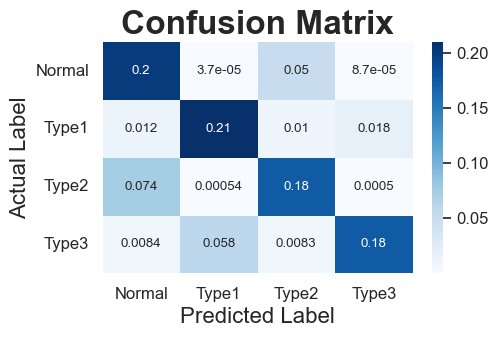

In [105]:
PATH = 'save/DNN_model/model.pt'

draw_confusion_matrix(x_test, y_test, PATH)

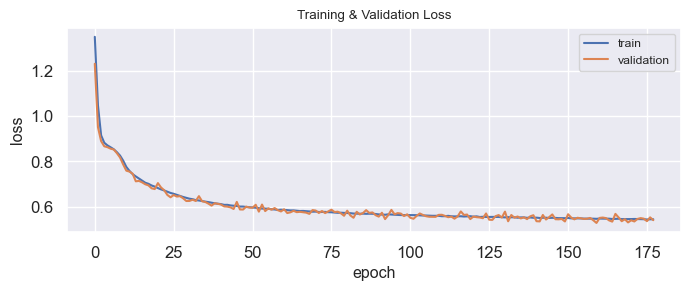

In [102]:
DNN_loss_matrix = pd.read_csv('./save/DNN_model/loss_values.csv')

# Extract the relevant columns from DNN_loss_matrix
DNN_train_loss = DNN_loss_matrix['DNN Train Loss']
DNN_valid_loss = DNN_loss_matrix['DNN Valid Loss']

plot_loss_graph(DNN_train_loss, DNN_valid_loss, './save/DNN_model/')

#### 5.2. CNN model performance

In [103]:
PATH ='save/CNN_model/'
test_model(PATH)

0.7487875


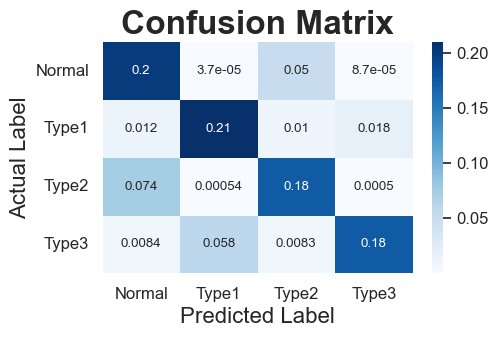

In [106]:
PATH = 'save/DNN_model/model.pt'

draw_confusion_matrix(x_test, y_test, PATH)

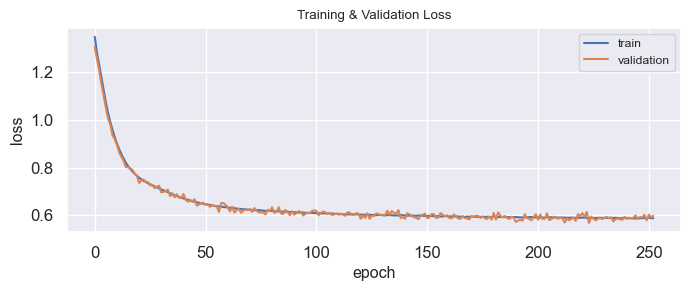

In [108]:
CNN_loss_matrix = pd.read_csv('./save/CNN_model/loss_values.csv')

# Extract the relevant columns from DNN_loss_matrix
CNN_train_loss = CNN_loss_matrix['CNN Train Loss']
CNN_valid_loss = CNN_loss_matrix['CNN Valid Loss']

plot_loss_graph(CNN_train_loss, CNN_valid_loss, './save/CNN_model/')

#### 5.3. RNN model performance

In [109]:
PATH ='save/RNN_model/'
test_model(PATH)

0.7715375


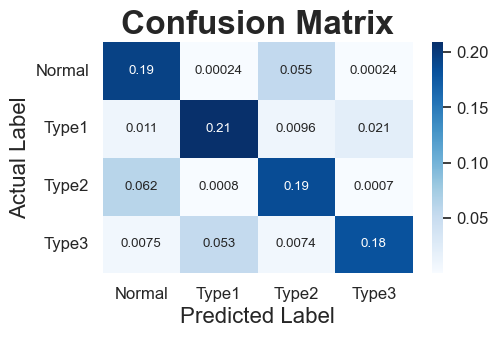

In [110]:
PATH = 'save/RNN_model/model.pt'

draw_confusion_matrix(x_test, y_test, PATH)

In [ ]:
RNN_loss_matrix = pd.read_csv('./save/RNN_model/loss_values.csv')

# Extract the relevant columns from DNN_loss_matrix
RNN_train_loss = RNN_loss_matrix['RNN Train Loss']
RNN_valid_loss = RNN_loss_matrix['RNN Valid Loss']

plot_loss_graph(RNN_train_loss, RNN_valid_loss, './save/RNN_model/')